In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
import os

# Check contents of the folder to verify the path
folder_path = '/content/drive/MyDrive/My dataset'
print(os.listdir(folder_path))


['.DS_Store', 'Akshay Kumar', 'Prabhas', 'Amitabh Bachchan', 'vijay']


In [3]:
import cv2
import numpy as np
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a function to preprocess an image (applying multiple transformations)
def preprocess_image(img):
    # Grayscale Conversion
    gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Red and Blue Scaling
    img[:, :, 0] = img[:, :, 0] * random.uniform(0.5, 1.5)  # Blue Channel
    img[:, :, 2] = img[:, :, 2] * random.uniform(0.5, 1.5)  # Red Channel

    # Histogram Equalization
    gray_img = cv2.equalizeHist(gray_img)

    # Resize image to a standard size (128x128)
    img_resized = cv2.resize(img, (128, 128))

    # Brightness/Contrast Adjustment
    alpha = random.uniform(0.7, 1.3)  # Contrast control
    beta = random.randint(-30, 30)    # Brightness control
    img_bright_contrast = cv2.convertScaleAbs(img_resized, alpha=alpha, beta=beta)

    # Blurring
    img_blurred = cv2.GaussianBlur(img_bright_contrast, (5, 5), 0)

    # Edge Detection
    edges = cv2.Canny(img_blurred, 100, 200)

    # Sharpening (using a kernel)
    kernel = np.array([[0, -1, 0], [-1, 5, -1], [0, -1, 0]])  # Sharpening kernel
    img_sharpened = cv2.filter2D(img_bright_contrast, -1, kernel)

    return img_sharpened  # Return the preprocessed image

# Augmentation using ImageDataGenerator
train_datagen = ImageDataGenerator(
    rescale=1./255,  # Normalize the pixel values
    rotation_range=30,  # Random rotations up to 30 degrees
    width_shift_range=0.2,  # Shift images horizontally
    height_shift_range=0.2,  # Shift images vertically
    shear_range=0.2,  # Shear transformation
    zoom_range=0.2,  # Random zooming
    horizontal_flip=True,  # Random horizontal flipping
    fill_mode='nearest',  # Fill the empty pixels after transformations
    validation_split=0.2  # Split the dataset into training and validation
)

# Load images from directory
train_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/My dataset',  # Path to your directory containing the images
    target_size=(128, 128),  # Resize the images to 128x128
    batch_size=32,  # Number of images per batch
    class_mode='categorical',  # Multiple classes
    subset='training'  # This will use the training subset
)

val_data = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/My dataset',
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical',
    subset='validation'  # Use the validation subset
)

print("Data loading and augmentation completed.")


Found 940 images belonging to 4 classes.
Found 232 images belonging to 4 classes.
Data loading and augmentation completed.


In [9]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_data.classes),
    y=train_data.classes
)
class_weights_dict = dict(enumerate(class_weights))


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.applications import VGG16
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

# Load VGG16 pre-trained model
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))

# Unfreeze the last 4 layers of the base model for fine-tuning
for layer in base_model.layers[-4:]:
    layer.trainable = True

# Build the model
model = Sequential([
    base_model,
    Flatten(),
    Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.5),
    Dense(len(train_data.class_indices), activation='softmax')
])

# Compile the model with SGD and momentum
optimizer = SGD(learning_rate=0.001, momentum=0.9)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

# Train the model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=30,
    batch_size=32,
    callbacks=[early_stopping, lr_scheduler],
    class_weight=class_weights_dict  # Add if dataset is imbalanced
)

# Save the trained model
model.save('/content/actor_model_finetuned.h5')
print("Model trained and saved.")


Epoch 1/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 52s 933ms/step - accuracy: 0.2786 - loss: 2.5433 - val_accuracy: 0.2414 - val_loss: 2.5095 - learning_rate: 0.0010
Epoch 2/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 50s 554ms/step - accuracy: 0.3632 - loss: 2.3396 - val_accuracy: 0.4397 - val_loss: 2.1482 - learning_rate: 0.0010
Epoch 3/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 19s 488ms/step - accuracy: 0.4845 - loss: 2.0964 - val_accuracy: 0.4440 - val_loss: 2.1369 - learning_rate: 0.0010
Epoch 4/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 23s 565ms/step - accuracy: 0.5853 - loss: 1.9789 - val_accuracy: 0.6164 - val_loss: 1.9341 - learning_rate: 0.0010
Epoch 5/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 487ms/step - accuracy: 0.6151 - loss: 1.8730 - val_accuracy: 0.5991 - val_loss: 1.8780 - learning_rate: 0.0010
Epoch 6/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 468ms/step - accuracy: 0.6857 - loss: 1.7455 - val_accuracy: 0.6681 - val_loss: 1.7412 - learning_rate: 0.0010
Epoch 7/30
30/30 ━━━━━━━━━━━━━━━━━━━━ 17s 457ms/step - accuracy: 0.7043 - loss: 1.

Model trained and saved.


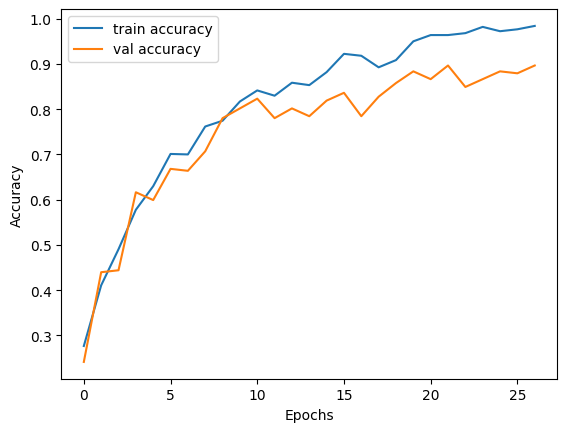

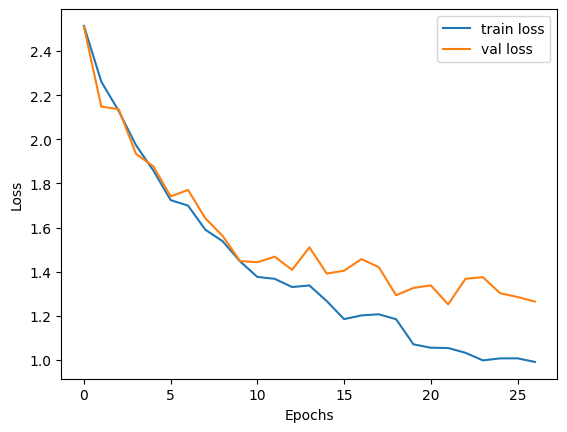

In [11]:
import matplotlib.pyplot as plt

# Plot training and validation accuracy/loss
plt.plot(history.history['accuracy'], label='train accuracy')
plt.plot(history.history['val_accuracy'], label='val accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


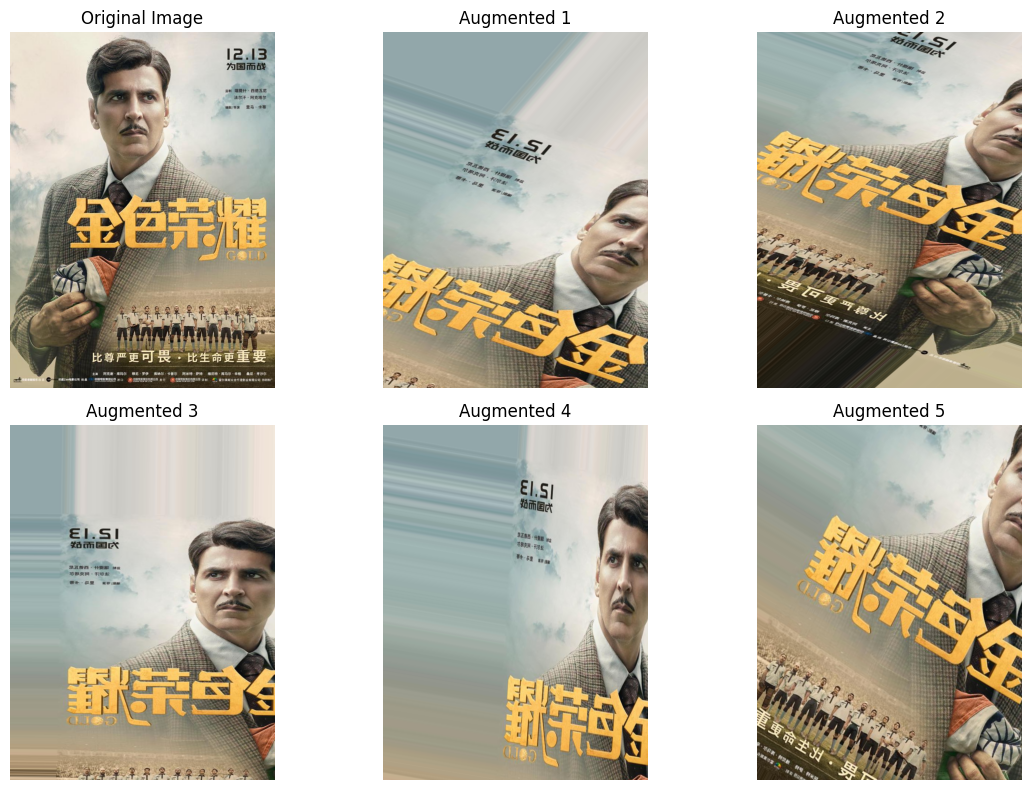

In [13]:
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

# Load a sample image (replace with your own image path)
image_path = "/content/drive/MyDrive/My dataset/Akshay Kumar/1.jpg"  # Change this path to your image
img = load_img(image_path)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

# Initialize the ImageDataGenerator for various transformations
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.4,
    height_shift_range=0.4,
    shear_range=0.4,
    zoom_range=0.4,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Apply transformations
#augmented_images = []
aug_iter = train_datagen.flow(img_array, batch_size=1)

# Plot original image and augmented versions
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

# Display original image
axes[0, 0].imshow(img)
axes[0, 0].set_title("Original Image")
axes[0, 0].axis('off')

# Generate and display augmented images
for i in range(1, 6):  # Start from index 1 because 0 is for the original image
    augmented_img = next(aug_iter)  # Get the next augmented image
    axes[i // 3, i % 3].imshow(augmented_img[0])  # Use [0] to get the image from the batch
    axes[i // 3, i % 3].set_title(f"Augmented {i}")
    axes[i // 3, i % 3].axis('off')
plt.tight_layout()
plt.show()


In [14]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Load the trained model
model = load_model('/content/actor_model_finetuned.h5')

print("Model loaded successfully.")


Model loaded successfully.


In [15]:
# Evaluate on validation data
val_loss, val_accuracy = model.evaluate(val_data)

print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 366ms/step - accuracy: 0.8540 - loss: 1.3256
Validation Accuracy: 84.91%
Validation Loss: 1.3407


In [16]:
# Predict classes
predictions = model.predict(val_data)
predicted_classes = np.argmax(predictions, axis=1)

# True classes from validation data
true_classes = val_data.classes
class_labels = list(val_data.class_indices.keys())  # ['amitabh_bachan', 'akshay_kumar', 'vijay', 'prabhas']

print("Predictions generated.")


8/8 ━━━━━━━━━━━━━━━━━━━━ 4s 365ms/step
Predictions generated.


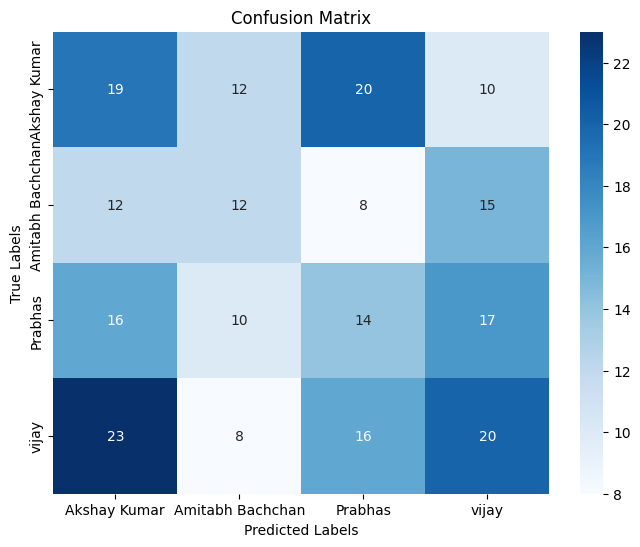

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Confusion Matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()


In [20]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load a sample image
img_path = '/content/drive/MyDrive/My dataset/Akshay Kumar/1.jpg'  # Replace with an image path
img = load_img(img_path, target_size=(128, 128))
img_array = img_to_array(img) / 255.0  # Normalize
img_array = np.expand_dims(img_array, axis=0)

# Predict the class
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]

print(f"The model predicts: {predicted_class}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
The model predicts: Akshay Kumar
